## 1. 讀取股票數據

In [1]:
import numpy as np
import requests
import pandas as pd
import datetime
import time
import yfinance as yf
from tqdm import tqdm
import mplfinance as mpf
import ta
import matplotlib
import matplotlib.pyplot as plt
import pandas_ta

In [2]:
STOCK_CODE = '2330'

In [3]:
def download_stock_data(stock_code):
    historical_data = pd.DataFrame()
    stock_id = stock_code + '.TW'
    data = yf.Ticker(stock_id)
    df = data.history(period="max")
    historical_data = pd.concat([historical_data, df])
    time.sleep(0.8)
    df.index = df.index.strftime('%Y-%m-%d')
    historical_data.to_csv('./' + stock_code + '.csv', index=True)

In [4]:
download_stock_data(STOCK_CODE)

In [5]:
df = pd.read_csv(STOCK_CODE + '.csv', index_col='Date', parse_dates=True)

In [6]:
df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-04 00:00:00+08:00,35.203037,35.203037,34.609732,35.203037,200662336736,0.0,0.0
2000-01-05 00:00:00+08:00,35.203024,35.994034,34.807424,35.994034,402466805912,0.0,0.0
2000-01-06 00:00:00+08:00,35.796342,35.994048,35.203037,35.203037,197545715802,0.0,0.0
2000-01-07 00:00:00+08:00,34.016425,34.609730,33.620825,34.214130,235270344752,0.0,0.0
2000-01-10 00:00:00+08:00,35.203032,35.598443,34.609727,35.400738,276171685539,0.0,0.0
2000-01-11 00:00:00+08:00,35.796343,36.191753,34.609733,34.807438,277769544650,0.0,0.0
2000-01-12 00:00:00+08:00,35.005142,35.796341,34.807436,35.796341,216246806621,0.0,0.0
2000-01-13 00:00:00+08:00,35.796342,35.796342,35.203037,35.203037,147490954216,0.0,0.0
2000-01-14 00:00:00+08:00,35.598434,36.587339,35.400729,35.994034,288318964353,0.0,0.0


In [7]:
def transform_df(dataframe):
    for col_name in dataframe.columns:
        dataframe[col_name] = dataframe[col_name].round(2)
    new_dataframe = pd.DataFrame(index=dataframe.index)
    for i in range(5):
        new_dataframe[f"price({-i})"] = np.nan
    for i in range(5):
        new_dataframe[f"vol({-i})"] = np.nan
    for i in range(4, len(dataframe)):
        for j in range(5):
            new_dataframe.iloc[i, j] = dataframe.iloc[i-j, 3]  # fill price columns
            new_dataframe.iloc[i, j+5] = dataframe.iloc[i-j, 4]  # fill volume columns
    new_dataframe['up/down'] = dataframe.iloc[:, 3].diff()  # calculate difference between current and previous price
    new_dataframe.drop(new_dataframe.index[:5], inplace=True)  # remove first 5 rows
    return new_dataframe

In [8]:
new_df = transform_df(df)

In [9]:
new_df.head(10)

,price(0),price(-1),price(-2),price(-3),price(-4),vol(0),vol(-1),vol(-2),vol(-3),vol(-4),up/down
Date,,,,,,,,,,,
2000-01-11 00:00:00+08:00,34.81,35.40,34.21,35.20,35.99,2.777695e+11,2.761717e+11,2.352703e+11,1.975457e+11,4.024668e+11,-0.59
2000-01-12 00:00:00+08:00,35.80,34.81,35.40,34.21,35.20,2.162468e+11,2.777695e+11,2.761717e+11,2.352703e+11,1.975457e+11,0.99
2000-01-13 00:00:00+08:00,35.20,35.80,34.81,35.40,34.21,1.474910e+11,2.162468e+11,2.777695e+11,2.761717e+11,2.352703e+11,-0.60
2000-01-14 00:00:00+08:00,35.99,35.20,35.80,34.81,35.40,2.883190e+11,1.474910e+11,2.162468e+11,2.777695e+11,2.761717e+11,0.79
2000-01-17 00:00:00+08:00,36.98,35.99,35.20,35.80,34.81,1.552569e+11,2.883190e+11,1.474910e+11,2.162468e+11,2.777695e+11,0.99
2000-01-18 00:00:00+08:00,36.39,36.98,35.99,35.20,35.80,1.316480e+11,1.552569e+11,2.883190e+11,1.474910e+11,2.162468e+11,-0.59
2000-01-19 00:00:00+08:00,36.39,36.39,36.98,35.99,35.20,1.348487e+11,1.316480e+11,1.552569e+11,2.883190e+11,1.474910e+11,0.00
2000-01-20 00:00:00+08:00,35.99,36.39,36.39,36.98,35.99,1.257581e+11,1.348487e+11,1.316480e+11,1.552569e+11,2.883190e+11,-0.40
2000-01-21 00:00:00+08:00,36.79,35.99,36.39,36.39,36.98,1.133974e+11,1.257581e+11,1.348487e+11,1.316480e+11,1.552569e+11,0.80


## 2. 繪製K線圖與技術指標

In [10]:
def plot_candle(df, start_date, end_date):
    df_range = df[(df.index >= start_date) & (df.index <= end_date)]
    
    # Set up style and plot size
    mc = mpf.make_marketcolors(up='r',down='g')
    s  = mpf.make_mpf_style(marketcolors=mc)
    fig, ax = mpf.plot(df_range, type='candle', volume=True, figratio=(2,1), style=s, returnfig=True)

    # Set title and axis labels
    fig.suptitle('Candlestick Chart with Volume Bars', fontsize=14, y=0.98)
    ax[0].set_ylabel('Price (NTD)', fontsize=12)
    ax[1].set_ylabel('Volume', fontsize=12)
    
    return fig, ax

(<Figure size 1150x575 with 4 Axes>,
 [<Axes: ylabel='Price (NTD)'>,
  <Axes: ylabel='Volume'>,
  <Axes: ylabel='Volume  $10^{6}$'>,
  <Axes: >])

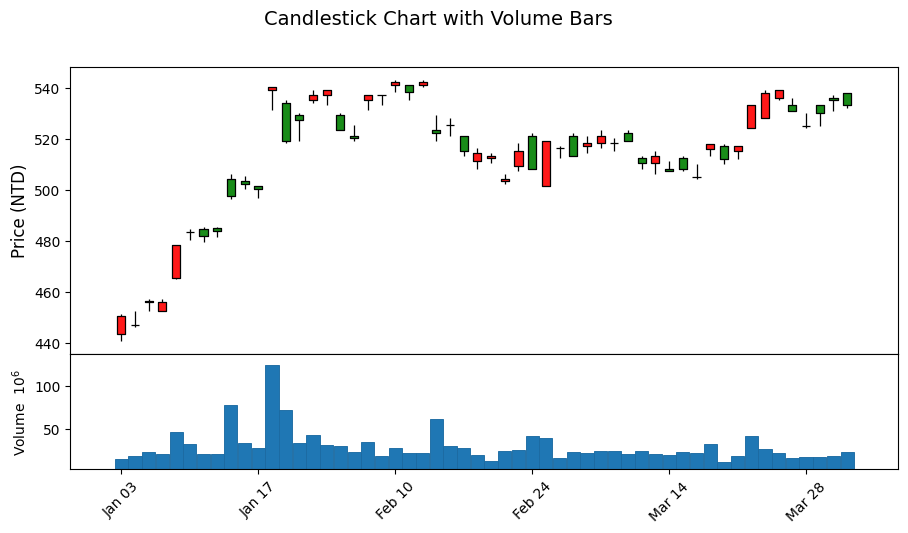

In [11]:
plot_candle(df, '2023-01-01', '2023-04-01')

In [12]:
# Calculate MACD and signal line
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['macd'] = macd.macd() # MACD Line
df['macd_histrogram'] = macd.macd_diff() # MACD Histogram
df['macd_signal'] = macd.macd_signal() # Signal Line

# Calculate RSI
rsi = ta.momentum.RSIIndicator(df['Close'], window=5)
df['rsi'] = rsi.rsi()

# Calculate KD
df.ta.stoch(high='high', low='low', k=9, d=3, append=True)
df = df.rename(columns={'STOCHk_9_3_3':'kd_k', 'STOCHd_9_3_3':'kd_d'})

# Calculate DMI
adx = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'], window=14)
df['dmi_plus'] = adx.adx_pos()
df['dmi_minus'] = adx.adx_neg()
df['adx'] = adx.adx()

C:\Users\benny\anaconda3\envs\KG\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\benny\anaconda3\envs\KG\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [13]:
def plot_indicators(df, start_date, end_date):
    df = df.loc[start_date:end_date].copy().dropna()
    fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

    # Plot KD
    if 'kd_k' in df.columns and 'kd_d' in df.columns:
        axs[0].plot(df.index, df['kd_k'], label='K')
        axs[0].plot(df.index, df['kd_d'], label='D')
        axs[0].set_ylabel('KD')
        axs[0].set_xlabel('Date')
        axs[0].legend()
    
    # Plot MACD
    if 'macd' in df.columns and 'macd_signal' in df.columns and 'macd_histrogram' in df.columns:
        axs[1].plot(df.index, df['macd'], label='MACD')
        axs[1].plot(df.index, df['macd_signal'], label='Signal')
        #bar_widths = np.diff(df.index.values).astype(np.int64) / 86400000000000
        axs[1].bar(df.index, 
                   df['macd_histrogram'],
                   width=1, 
                   align='edge', 
                   color=np.where(df['macd_histrogram'] < 0, 'g', 'r'), 
                   label='Histogram')
        axs[1].set_ylabel('MACD')
        axs[1].set_xlabel('Date')
        axs[1].legend()
       
    # Plot RSI
    if 'rsi' in df.columns:
        axs[2].plot(df.index, df['rsi'], label='RSI')
        axs[2].axhline(30, color='green', linestyle='--')
        axs[2].axhline(70, color='green', linestyle='--')
        axs[2].set_ylabel('RSI')
        axs[2].set_xlabel('Date')
        axs[2].legend()
    
    # Plot DMI
    if 'dmi_plus' in df.columns and 'dmi_minus' in df.columns and 'adx' in df.columns:
        axs[3].plot(df.index, df['dmi_plus'], label='+DMI')
        axs[3].plot(df.index, df['dmi_minus'], label='-DMI')
        axs[3].plot(df.index, df['adx'], label='ADX')
        axs[3].axhline(20, color='green', linestyle='--')
        axs[3].set_ylabel('DMI/ADX')
        axs[3].set_xlabel('Date')
        axs[3].legend()
    
    # Get trading dates from DataFrame
    trading_dates = df.index
    
    # Set x-ticks for each subplot
    for ax in axs:
        ax.set_xticks(trading_dates)
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))

        # Rotate x-tick labels for better visibility
        if len(df.loc[start_date:end_date]<90):
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    
    plt.show()

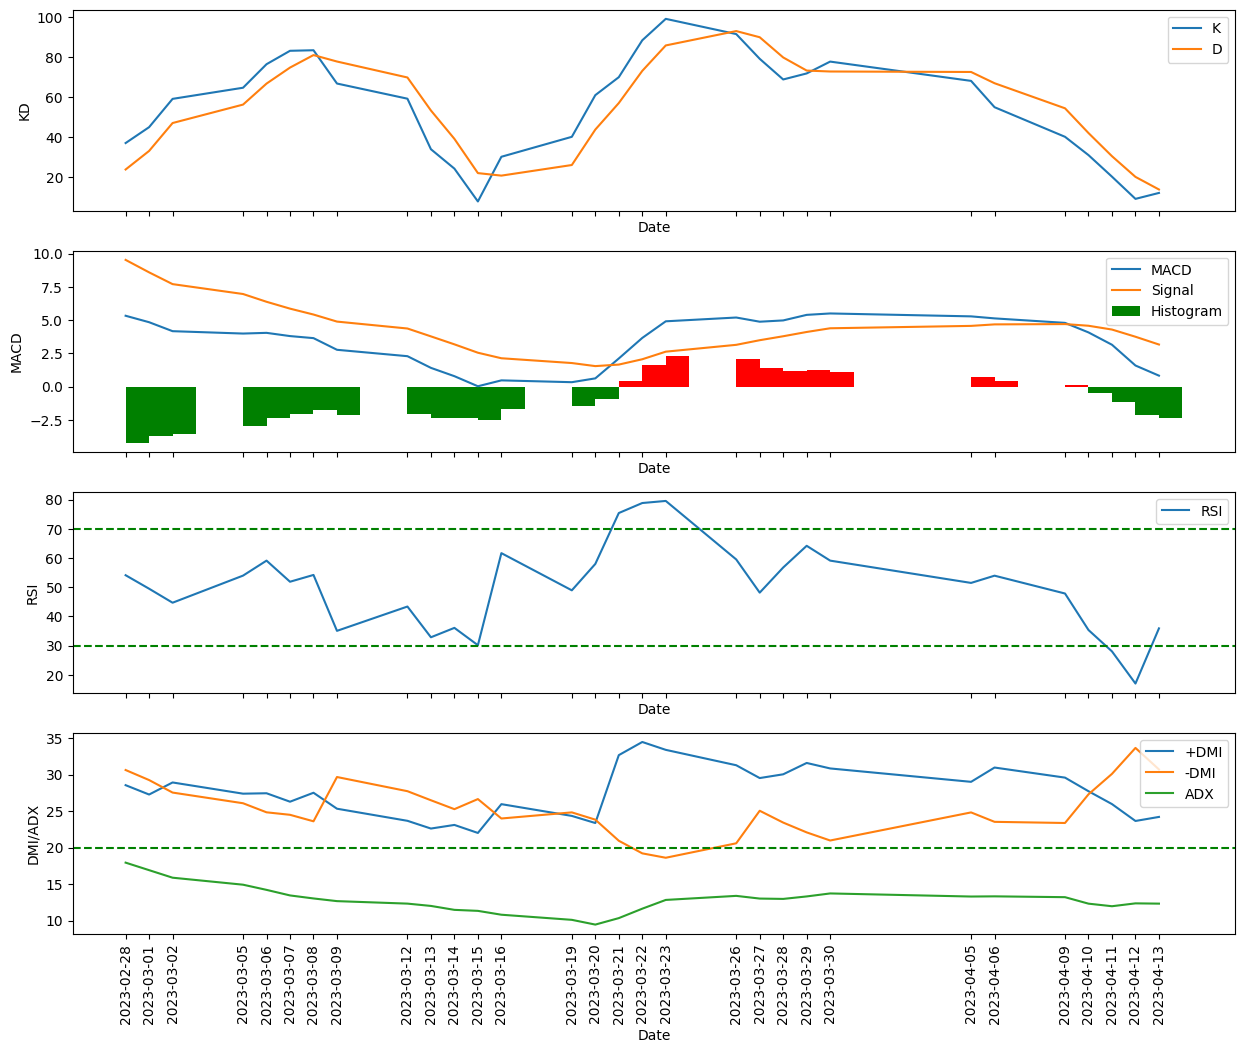

In [14]:
plot_indicators(df, '2023-03-01','2023-04-16') # The blanks of non-trading date are inevitable

## 3. 指定策略

In [15]:
dataset = pd.concat([new_df, df], axis=1)
up_down = dataset.pop('up/down')
dataset['Up_Down'] = up_down
dataset['Price(+1)'] = dataset['Close'].shift(-1)
dataset = dataset.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
dataset = dataset.dropna()

In [16]:
dataset.tail(20)

,price(0),price(-1),price(-2),price(-3),price(-4),vol(0),vol(-1),vol(-2),vol(-3),vol(-4),...,macd_histrogram,macd_signal,rsi,kd_k,kd_d,dmi_plus,dmi_minus,adx,Up_Down,Price(+1)
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-17 00:00:00+08:00,518.0,505.0,508.25,507.26,513.22,33118483.0,21965994.0,23208597.0,20474770.0,21466947.0,...,-1.662661,2.134150,61.664674,30.005149,20.568922,25.959680,23.993110,10.805065,13.0,512.0
2023-03-20 00:00:00+08:00,512.0,518.0,505.00,508.25,507.26,11837312.0,33118483.0,21965994.0,23208597.0,20474770.0,...,-1.439736,1.774216,48.926477,39.993045,25.876990,24.348329,24.831500,10.103450,-6.0,517.0
2023-03-21 00:00:00+08:00,517.0,512.0,518.00,505.00,508.25,18284799.0,11837312.0,33118483.0,21965994.0,23208597.0,...,-0.921624,1.543810,57.970378,60.858981,43.619058,23.371880,23.835675,9.451951,5.0,533.0
2023-03-22 00:00:00+08:00,533.0,517.0,512.00,518.00,505.00,42385987.0,18284799.0,11837312.0,33118483.0,21965994.0,...,0.458439,1.658420,75.396878,69.848722,56.900249,32.676177,20.941513,10.340083,16.0,538.0
2023-03-23 00:00:00+08:00,538.0,533.0,517.00,512.00,518.00,26728246.0,42385987.0,18284799.0,11837312.0,33118483.0,...,1.603373,2.059263,78.826235,88.319050,73.008918,34.480030,19.214185,11.632297,5.0,539.0
2023-03-24 00:00:00+08:00,539.0,538.0,533.00,517.00,512.00,21926240.0,26728246.0,42385987.0,18284799.0,11837312.0,...,2.281987,2.629760,79.539227,99.047619,85.738464,33.401133,18.612964,12.832210,1.0,531.0
2023-03-27 00:00:00+08:00,531.0,539.0,538.00,533.00,517.00,16111177.0,21926240.0,26728246.0,42385987.0,18284799.0,...,2.053188,3.143057,59.502674,91.428571,92.931747,31.292199,20.594729,13.388259,-8.0,525.0
2023-03-28 00:00:00+08:00,525.0,531.0,539.00,538.00,533.00,17234120.0,16111177.0,21926240.0,26728246.0,42385987.0,...,1.390589,3.490704,48.134952,79.047619,89.841270,29.534960,25.053798,13.018308,-6.0,530.0
2023-03-29 00:00:00+08:00,530.0,525.0,531.00,539.00,538.00,17280749.0,17234120.0,16111177.0,21926240.0,26728246.0,...,1.189652,3.788117,56.743288,68.702791,79.726327,30.049874,23.434150,12.971967,5.0,535.0


In [17]:
BUY = 1
SELL = -1
DO_NOTHING = 0

### (1) 純MACD戰法

In [18]:
def pure_MACD_strategy(dataset, date):
    # Get the row for the given date
    date = pd.to_datetime(date)
    row = dataset.loc[date]

    # get the previous row
    row_loc = dataset.index.get_loc(date)
    prev_row = dataset.iloc[row_loc - 1]
    
    # Check if histogram was negative on the previous day and is now positive
    if prev_row['macd_histrogram'] < 0 and row['macd_histrogram'] > 0:
        return BUY # Buy
    # Check if histogram was positive on the previous day and is now negative
    elif prev_row['macd_histrogram'] > 0 and row['macd_histrogram'] < 0:
        return SELL # Sell
    
    return DO_NOTHING # Do nothing

### (2) 純KD戰法

In [19]:
def pure_KD_strategy(dataset, date):
    # Get the row for the given date
    date = pd.to_datetime(date)
    row = dataset.loc[date]

    # get the previous row
    row_loc = dataset.index.get_loc(date)
    prev_row = dataset.iloc[row_loc - 1]
    
    # Check if both kd_k and kd_d were below 20 on the previous day
    if prev_row['kd_k'] < 20 and prev_row['kd_d'] < 20:
        # Check if kd_k is now above kd_d
        if row['kd_k'] > row['kd_d'] and \
        prev_row['kd_k'] < prev_row['kd_d']:
            return BUY # Buy
    # Check if both kd_k and kd_d were above 80 on the previous day
    elif prev_row['kd_k'] > 80 and prev_row['kd_d'] > 80:
        # Check if kd_k is now below kd_d
        if row['kd_k'] < row['kd_d'] and \
        prev_row['kd_k'] > prev_row['kd_d']:
            return SELL # Sell
    
    return DO_NOTHING # Do nothing

### (3) 純RSI戰法

In [20]:
def pure_RSI_strategy(dataset, date):
    # Get the row for the given date
    date = pd.to_datetime(date)
    row = dataset.loc[date]

    # get the previous row
    row_loc = dataset.index.get_loc(date)
    prev_row = dataset.iloc[row_loc - 1]
    
    # Check if RSI was below 30 on the previous day and is now above 30
    if prev_row['rsi'] < 30 and row['rsi'] > 30:
        return BUY # Buy
    # Check if RSI was above 70 on the previous day and is now below 70
    elif prev_row['rsi'] > 70 and row['rsi'] < 70:
        return SELL # Sell
    
    return DO_NOTHING # Do nothing

### (4) 純DMI戰法

In [21]:
def pure_DMI_strategy(dataset, date):
    # Get the index of the date
    idx = dataset.index.get_loc(date)
    
    # Check if there are at least two data points before the given date
    if idx < 2:
        return DO_NOTHING
    
    # Check if DMI+ is above DMI- and ADX is above 20 on the previous day
    if dataset['dmi_plus'].iloc[idx-1] > dataset['dmi_minus'].iloc[idx-1] and dataset['adx'].iloc[idx-1] > 20:
        # Buy the stock if DMI+ is above DMI- and ADX is above 20 today
        if dataset['dmi_plus'].iloc[idx] > dataset['dmi_minus'].iloc[idx] and dataset['adx'].iloc[idx] > 20:
            return BUY
    # Check if DMI- is above DMI+ and ADX is above 20 on the previous day
    elif dataset['dmi_minus'].iloc[idx-1] > dataset['dmi_plus'].iloc[idx-1] and dataset['adx'].iloc[idx-1] > 20:
        # Sell the stock if DMI- is above DMI+ and ADX is above 20 today
        if dataset['dmi_minus'].iloc[idx] > dataset['dmi_plus'].iloc[idx] and dataset['adx'].iloc[idx] > 20:
            return SELL
    
    # Do nothing if none of the conditions are satisfied
    return DO_NOTHING

## 4. 進行回測

In [22]:
def backtest(input_data, strategy, start_date, end_date):
    """
    Backtests the given strategy on the stock data between start and end dates.
    
    Args:
        stock_data (DataFrame): A DataFrame containing the stock data with columns 'Date' and 'price(0)'.
        strategy (function): A function that takes a DataFrame and a date, and returns a trading decision.
        start_date (str): The start date of the backtest in the format 'YYYY-MM-DD'.
        end_date (str): The end date of the backtest in the format 'YYYY-MM-DD'.
        
    Returns:
        dict: A dictionary containing the following keys:
            - 'buy_dates' (list): A list of dates on which stocks were bought.
            - 'sell_dates' (list): A list of dates on which stocks were sold.
            - 'cost_of_investment' (float): The total cost of investment during the backtest period.
            - 'net_income' (float): The total net income earned during the backtest period.
            - 'roi' (float): The ROI for the backtest period.
    """
    # Convert start and end dates to datetime objects
    start_date = pd.to_datetime(start_date).tz_localize('UTC').tz_convert(tz='Asia/Taipei')
    end_date = pd.to_datetime(end_date).tz_localize('UTC').tz_convert(tz='Asia/Taipei')
    
    # Filter stock data to include only the backtest period
    backtest_data = input_data.loc[(input_data.index >= start_date) & (input_data.index <= end_date)].copy()
    
    # Initialize variables
    buy_dates = []
    sell_dates = []
    cost_of_investment = 0.0
    net_income = 0.0
    current_status = 'NO POSITION'
    
    # Loop over each day in the backtest period
    for date in tqdm(backtest_data.index):
        # Get the date and the trading decision for the current day
        date = date.strftime('%Y-%m-%d %H:%M:%S%z')
        decision = strategy(input_data, date)
        
        # If the decision is to buy, record the buy date and add the cost of investment
        if decision == 1 and current_status == 'NO POSITION':
            buy_dates.append(date)
            cost_of_investment += input_data.loc[date, 'price(0)']
            current_status = 'LONG'
        
        # If the decision is to sell, record the sell date and subtract the net income
        elif decision == -1 and current_status == 'LONG': #做多
            sell_dates.append(date)
            net_income += input_data.loc[date, 'price(0)']
            current_status = 'NO POSITION'
            
    # If we're still holding a long position at the end of the backtest period, sell it
    if current_status == 'LONG':
        last_date = backtest_data.index[-1].strftime('%Y-%m-%d %H:%M:%S%z')
        sell_dates.append(last_date)
        net_income += input_data.loc[last_date, 'price(0)']
        
    # Calculate the ROI
    roi = (net_income / cost_of_investment) - 1 - 0.004 # 0.004大約是交易手續費與證交稅的比率
    
    # Create the result dictionary
    result = {
        'buy_dates': buy_dates,
        'sell_dates': sell_dates,
        'cost_of_investment': cost_of_investment,
        'net_income': net_income,
        'roi': roi
    }
    
    return result

In [27]:
backtest_result = backtest(dataset, pure_KD_strategy, '2020-01-01', '2021-04-19')
print(backtest_result)

100%|██████████████████████████████████████████████████████████████████████████████| 310/310 [00:00<00:00, 5053.61it/s]

{'buy_dates': ['2020-02-04 00:00:00+0800', '2020-03-03 00:00:00+0800', '2020-09-09 00:00:00+0800', '2020-09-28 00:00:00+0800', '2020-11-02 00:00:00+0800', '2021-02-02 00:00:00+0800', '2021-03-04 00:00:00+0800'], 'sell_dates': ['2020-02-17 00:00:00+0800', '2020-04-10 00:00:00+0800', '2020-09-17 00:00:00+0800', '2020-10-14 00:00:00+0800', '2020-11-17 00:00:00+0800', '2021-02-22 00:00:00+0800', '2021-04-12 00:00:00+0800'], 'cost_of_investment': 3006.01, 'net_income': 3099.0899999999997, 'roi': 0.026964634182853556}


## 5. 進行統計學習預測股價